In [1]:
!pip install XGBoost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install seaborn==0.9.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('s3://partly-cloudy-ml-inputs/JACKSONVILLE_every_6_hour_flat.csv')
df.head()

,localDateTime,Nx,Ny,Lat,Lon,geoEncode,NAME,iSSRs200430,iSSRs300430,meanTemp200430,meanTemp300430,meanRH_ice200430,meanRH_ice300430
0,2020-06-01 00:00:00,213,65,31.056881,-84.810568,dje8w,JACKSONVILLE,0,0,239.546667,226.763333,34.124167,56.171667
1,2020-07-18 12:00:00,213,65,31.056881,-84.810568,dje8w,JACKSONVILLE,0,0,240.078917,227.007333,20.545000,30.785000
2,2020-08-20 06:00:00,213,65,31.056881,-84.810568,dje8w,JACKSONVILLE,0,0,238.541333,225.994333,85.386667,90.733333
3,2020-09-27 12:00:00,213,65,31.056881,-84.810568,dje8w,JACKSONVILLE,0,0,240.756833,227.694500,76.864167,52.861667
4,2021-02-27 00:00:00,213,65,31.056881,-84.810568,dje8w,JACKSONVILLE,0,0,236.391500,224.716333,29.560833,48.126667


In [3]:
#Creating a subset of the dataframe - Going to just look at ISSRs at FL 300 to FL 370
df = df[['localDateTime', 'iSSRs300430','Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']]
df = df.rename(columns={'iSSRs300430': 'ISSRCount'})
df.head()

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
0,2020-06-01 00:00:00,0,213,65,226.763333,56.171667
1,2020-07-18 12:00:00,0,213,65,227.007333,30.785000
2,2020-08-20 06:00:00,0,213,65,225.994333,90.733333
3,2020-09-27 12:00:00,0,213,65,227.694500,52.861667
4,2021-02-27 00:00:00,0,213,65,224.716333,48.126667


In [4]:
#Convert variables into appropriate formats for analysis
#1. localDateTime -> Date object
df['localDateTime'] = pd.to_datetime(df['localDateTime'], infer_datetime_format=True)
#Check change has occured
#df.info()

In [5]:
#df.sort_values('localDateTime')

In [6]:
#test date is randomly picked - 2020/9/5
df = df[df.localDateTime <= '2020-09-06 00:00:00']
df = df[df.localDateTime >= '2020-08-05 00:00:00']
df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
2,2020-08-20 06:00:00,0,213,65,225.994333,90.733333
21,2020-08-08 18:00:00,0,213,65,227.850167,57.976667
22,2020-08-11 12:00:00,0,213,65,227.688500,78.018333
44,2020-08-10 18:00:00,2,213,65,228.383833,92.471667
53,2020-09-04 12:00:00,0,213,65,228.730667,49.410000
...,...,...,...,...,...,...
1834211,2020-08-12 18:00:00,0,222,55,228.590333,77.890000
1834225,2020-08-17 06:00:00,1,222,55,226.937833,81.921667
1834226,2020-08-26 06:00:00,2,222,55,230.525000,66.105000
1834237,2020-08-08 00:00:00,0,222,55,227.651500,68.630000


In [7]:
features = ['Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']
label = 'ISSRCount'
test_df = df[df.localDateTime >= '2020-09-05 00:00:00']
train_df = df[df.localDateTime < '2020-09-05 00:00:00']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [8]:
params = { 'max_depth': [3, 6, 10, 15],
           'learning_rate': [0.01, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0),
           'colsample_bylevel': np.arange(0.4, 1.0),
           'n_estimators': [100, 500]}

In [9]:
xgbr = xgb.XGBRegressor(seed = 20)

In [10]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         n_iter=25,
                         verbose=1)

In [11]:
reg = clf.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-mae:0.50793	validation_1-mae:0.45803
[1]	validation_0-mae:0.46563	validation_1-mae:0.41389
[2]	validation_0-mae:0.43178	validation_1-mae:0.37859
[3]	validation_0-mae:0.40483	validation_1-mae:0.35048
[4]	validation_0-mae:0.38221	validation_1-mae:0.32429
[5]	validation_0-mae:0.36401	validation_1-mae:0.30345
[6]	validation_0-mae:0.35017	validation_1-mae:0.28903
[7]	validation_0-mae:0.33902	validation_1-mae:0.27741
[8]	validation_0-mae:0.30273	validation_1-mae:0.24534
[9]	validation_0-mae:0.29568	validation_1-mae:0.23801
[10]	validation_0-mae:0.29009	validation_1-mae:0.23219
[11]	validation_0-mae:0.28548	validation_1-mae:0.22740
[12]	validation_0-mae:0.25994	validation_1-mae:0.20595
[13]	validation_0-mae:0.23988	validation_1-mae:0.18745
[14]	validation_0-mae:0.23754	validation_1-mae:0.18509
[15]	validation_0-mae:0.23563	validation_1-mae:0.18315
[16]	validation_0-mae:0.23372	validation_1-mae:0.18159
[17]	validati

In [12]:
print("Best parameters:", clf.best_params_)

Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}


In [13]:
#print("Lowest RMSE:", (clf.best_score)**(1/2.0))

In [14]:
#reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
#reg.fit(X_train,
#        y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        eval_metric='mae')

In [15]:
y_pred = reg.predict(X_test)

In [16]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['y_pred'] = pd.Series(y_pred)

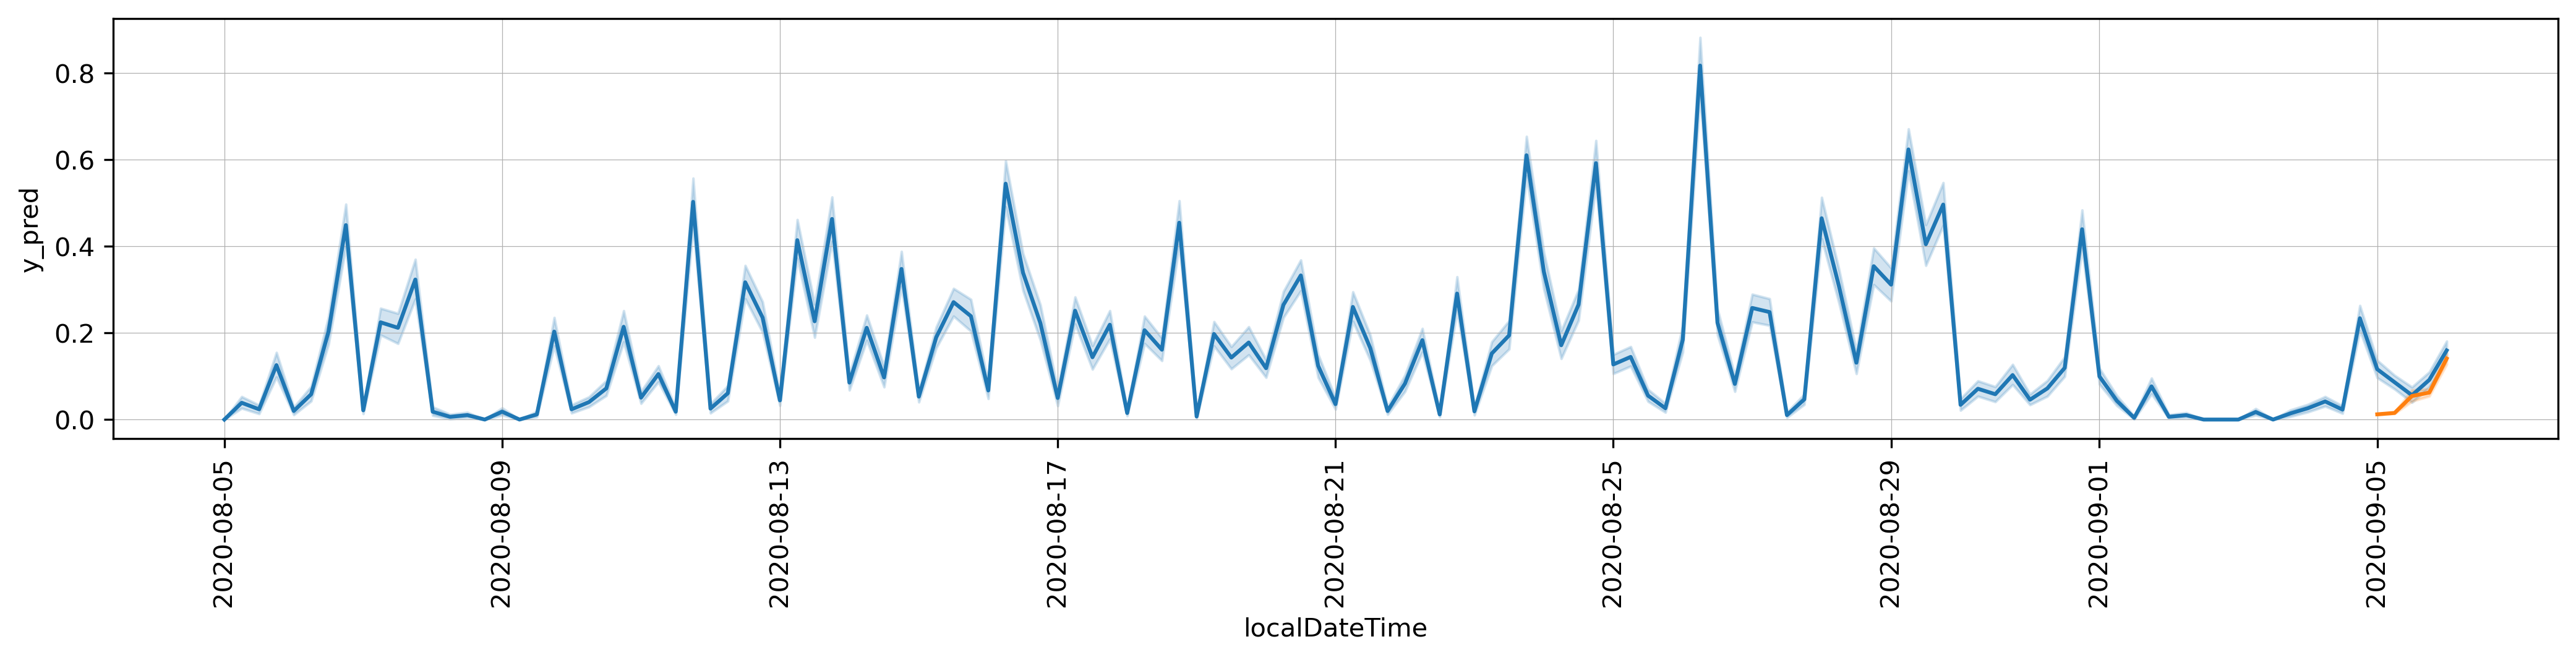

In [17]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=df, x='localDateTime',y='ISSRCount')
sns.lineplot(data=test_df, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [18]:
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-09-05 12:00:00,0,213,65,228.594167,55.450000,-0.004665
1,2020-09-05 18:00:00,0,213,65,228.391167,74.551667,0.062889
2,2020-09-06 00:00:00,0,213,65,228.335000,80.115000,0.101772
3,2020-09-05 06:00:00,0,213,65,228.424667,57.671667,0.007442
4,2020-09-05 00:00:00,0,213,65,228.966667,51.346667,0.008858
...,...,...,...,...,...,...,...
6320,2020-09-05 18:00:00,0,222,55,228.630667,70.535000,0.012650
6321,2020-09-05 00:00:00,0,222,55,228.945833,71.853333,0.023926
6322,2020-09-05 12:00:00,0,222,55,228.469333,79.738333,0.055032
6323,2020-09-05 06:00:00,0,222,55,228.684833,80.325000,0.041309


In [19]:
test_df['y_pred'] = round(test_df['y_pred'],0)
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-09-05 12:00:00,0,213,65,228.594167,55.450000,-0.0
1,2020-09-05 18:00:00,0,213,65,228.391167,74.551667,0.0
2,2020-09-06 00:00:00,0,213,65,228.335000,80.115000,0.0
3,2020-09-05 06:00:00,0,213,65,228.424667,57.671667,0.0
4,2020-09-05 00:00:00,0,213,65,228.966667,51.346667,0.0
...,...,...,...,...,...,...,...
6320,2020-09-05 18:00:00,0,222,55,228.630667,70.535000,0.0
6321,2020-09-05 00:00:00,0,222,55,228.945833,71.853333,0.0
6322,2020-09-05 12:00:00,0,222,55,228.469333,79.738333,0.0
6323,2020-09-05 06:00:00,0,222,55,228.684833,80.325000,0.0


In [20]:
test_df['y_pred'].describe()

count    6325.000000
mean        0.022925
std         0.174092
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: y_pred, dtype: float64

In [21]:
test_df['ISSRCount'].describe()

count    6325.000000
mean        0.101976
std         0.347401
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ISSRCount, dtype: float64

In [22]:
test_df['localDateTime'] = pd.to_datetime(test_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts = test_df[['localDateTime', 'ISSRCount', 'y_pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='localDateTime').sum()

           localDateTime  ISSRCount  y_pred
0    2020-09-05 12:00:00          0    -0.0
1    2020-09-05 18:00:00          0     0.0
2    2020-09-06 00:00:00          0     0.0
3    2020-09-05 06:00:00          0     0.0
4    2020-09-05 00:00:00          0     0.0
...                  ...        ...     ...
6320 2020-09-05 18:00:00          0     0.0
6321 2020-09-05 00:00:00          0     0.0
6322 2020-09-05 12:00:00          0     0.0
6323 2020-09-05 06:00:00          0     0.0
6324 2020-09-06 00:00:00          0     0.0

[6325 rows x 3 columns]


,ISSRCount,y_pred
localDateTime,,
2020-09-05,443,66.0
2020-09-06,202,79.0


In [23]:
#Examines sum of ISSRs in 6 hour time intervals
df_sum = df_ISSR_counts.resample('6H', on='localDateTime').sum()
df_sum

,ISSRCount,y_pred
localDateTime,,
2020-09-05 00:00:00,147,0.0
2020-09-05 06:00:00,109,0.0
2020-09-05 12:00:00,71,35.0
2020-09-05 18:00:00,116,31.0
2020-09-06 00:00:00,202,79.0


In [24]:
# convert the index to column
df_sum.reset_index(inplace=True)
df_sum

,localDateTime,ISSRCount,y_pred
0,2020-09-05 00:00:00,147,0.0
1,2020-09-05 06:00:00,109,0.0
2,2020-09-05 12:00:00,71,35.0
3,2020-09-05 18:00:00,116,31.0
4,2020-09-06 00:00:00,202,79.0


In [25]:
train_df['localDateTime'] = pd.to_datetime(train_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts_train = train_df[['localDateTime', 'ISSRCount']].copy()
print(df_ISSR_counts_train)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts_train.resample('D', on='localDateTime').sum()
df_sum_train = df_ISSR_counts_train.resample('6H', on='localDateTime').sum()

              localDateTime  ISSRCount
2       2020-08-20 06:00:00          0
21      2020-08-08 18:00:00          0
22      2020-08-11 12:00:00          0
44      2020-08-10 18:00:00          2
53      2020-09-04 12:00:00          0
...                     ...        ...
1834211 2020-08-12 18:00:00          0
1834225 2020-08-17 06:00:00          1
1834226 2020-08-26 06:00:00          2
1834237 2020-08-08 00:00:00          0
1834238 2020-08-27 00:00:00          0

[156860 rows x 2 columns]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [26]:
# convert the index to column
df_sum_train.reset_index(inplace=True)
df_sum_train

,localDateTime,ISSRCount
0,2020-08-05 00:00:00,0
1,2020-08-05 06:00:00,49
2,2020-08-05 12:00:00,30
3,2020-08-05 18:00:00,159
4,2020-08-06 00:00:00,25
...,...,...
119,2020-09-03 18:00:00,18
120,2020-09-04 00:00:00,33
121,2020-09-04 06:00:00,53
122,2020-09-04 12:00:00,29


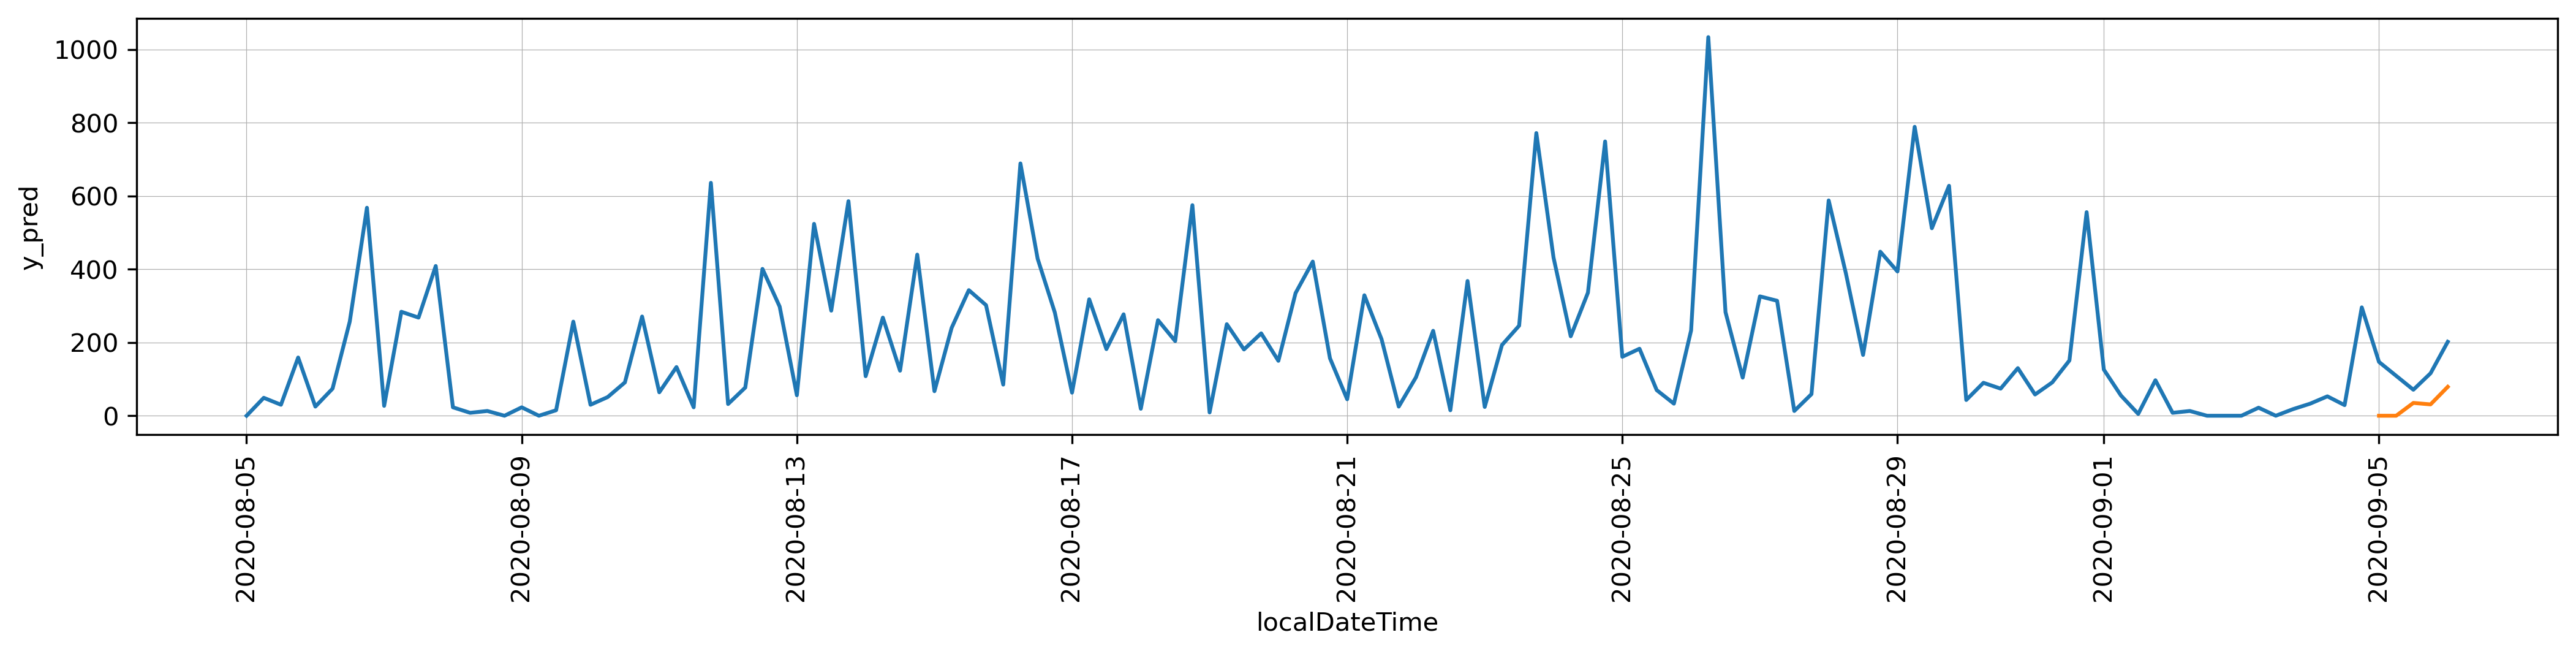

In [27]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=pd.concat([df_sum_train, df_sum]), x='localDateTime',y='ISSRCount')
sns.lineplot(data=df_sum, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [28]:
confusion_matrix = pd.crosstab(test_df['ISSRCount'], test_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,-0.0,1.0,2.0,3.0
Actual,,,,
0,5722,40,1,0
1,445,39,4,0
2,36,19,9,1
3,0,3,5,1


In [29]:
#from sklearn.metrics import plot_confusion_matrix
#disp = plot_confusion_matrix(reg, X_test, y_test,
#                           display_labels = label,
#                           cmap = plt.cm.Blues)
#plt.show()

IndentationError: unexpected indent (<ipython-input-29-055a4619c1fc>, line 3)

In [30]:
# For predicted value 0:
TP=5722
TN=81   #=39+4+0+19+9+1+3+5+1
FP=481  #=445+36+0
FN=41   #=40+1+0

In [31]:
# true positive rate
TP_rate = TP/(TP+FN)
print("True positive: %.2f%%" % (TP_rate* 100.0))
#Specificity or true negative rate
#TN_rate = TN/(TN+FP) 
#print("True negative: %.2f%%" % (TN_rate* 100.0))
# Precision or positive predictive value
Precision_rate = TP/(TP+FP)
print("Precision: %.2f%%" % (Precision_rate* 100.0))
# Negative predictive value
#NP_rate = TN/(TN+FN)
#print("Negative predictive: %.2f%%" % (NP_rate * 100.0))
# Fall out or false positive rate
FP_rate = FP/(FP+TN)
print("False Positive: %.2f%%" % (FP_rate * 100.0))
# False negative rate
FN_rate = FN/(TP+FN)
print("False Negative: %.2f%%" % (FN_rate * 100.0))
# False discovery rate
#FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy for count zero: %.2f%%" % (ACC * 100.0))

True positive: 99.29%
Precision: 92.25%
False Positive: 85.59%
False Negative: 0.71%
Overall accuracy for count zero: 91.75%


In [32]:
from sklearn.metrics import accuracy_score

In [33]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.24%


In [34]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print('MAE: ', mae)

MAE:  0.09391304347826086


In [35]:
#output bucket - S3 bucket designation
output_bucket = 'partly-cloudy-common-area'
outputFileName = 'XGBoost_Jacksonville_1month.csv'
#use wrangler to write the dataframe into a csv
import awswrangler as wr
wr.s3.to_csv(test_df, f"s3://{output_bucket}/{outputFileName}", index=False)

{'paths': ['s3://partly-cloudy-common-area/XGBoost_Jacksonville_1month.csv'],
 'partitions_values': {}}